# 1-Goemans-Williamson

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import cvxgraphalgs as cvxgr
from cvxgraphalgs.structures import Cut

LEFT_COLOR = 'blue'
RIGHT_COLOR = 'green'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1.1 Visualization & Analysis Tools

In [3]:
def sbm_graph(size, within, between):
    half = int(size / 2)
    left_side = np.random.choice(size, half, replace=False)
    left_side = set(left_side)
    
    cut = Cut(left_side, set())
    for vertex in range(size):
        if vertex not in left_side:
            cut.right.add(vertex)
    
    graph = cvxgr.generators.stochastic_block_on_cut(cut, within, between)
    return graph, cut

In [4]:
def visualize_cut(graph, cut):
    colors = []
    for vertex in graph.nodes:
        color = LEFT_COLOR if vertex in cut.left else RIGHT_COLOR
        colors.append(color)
    %matplotlib inline
    nx.draw(graph, node_color=colors)
    plt.show()

In [5]:
def average_performance(graph_generator, algorithm, trials=50):
    times, outputs = [], []
    for _ in range(trials):
        graph = graph_generator()
        
        start = time.clock()
        result = algorithm(graph)
        end = time.clock()
        elapsed = end - start
        
        times.append(elapsed)
        outputs.append(result.evaluate_cut_size(graph))
        
    return {
        'trials': trials,
        'time': np.mean(times),
        'output': np.mean(outputs)
    }

## 1.2 Examples on Small Planted Cuts

/Users/hermish/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


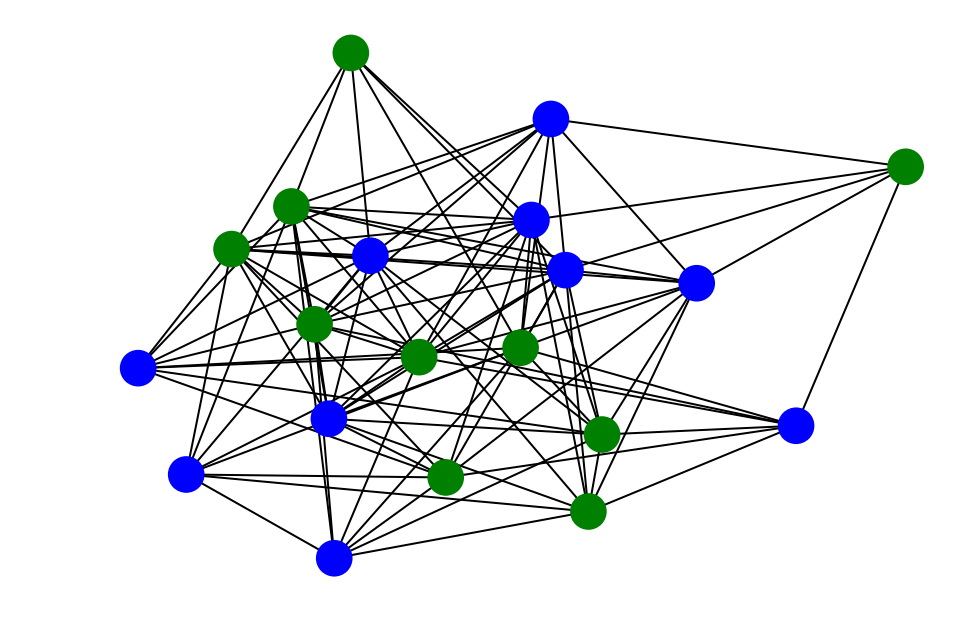

Planted Cut
Expected Size: 75.0
Real Size: 76


In [6]:
GRAPH_SIZE = 20
WITHIN = 0.25
BETWEEN = 0.75

graph, cut = sbm_graph(GRAPH_SIZE, WITHIN, BETWEEN)
visualize_cut(graph, cut)

print('Planted Cut')
print('Expected Size:', GRAPH_SIZE * GRAPH_SIZE * BETWEEN / 4)
print('Real Size:', cut.evaluate_cut_size(graph))

### 1.2.1 Random Cut Algorithm

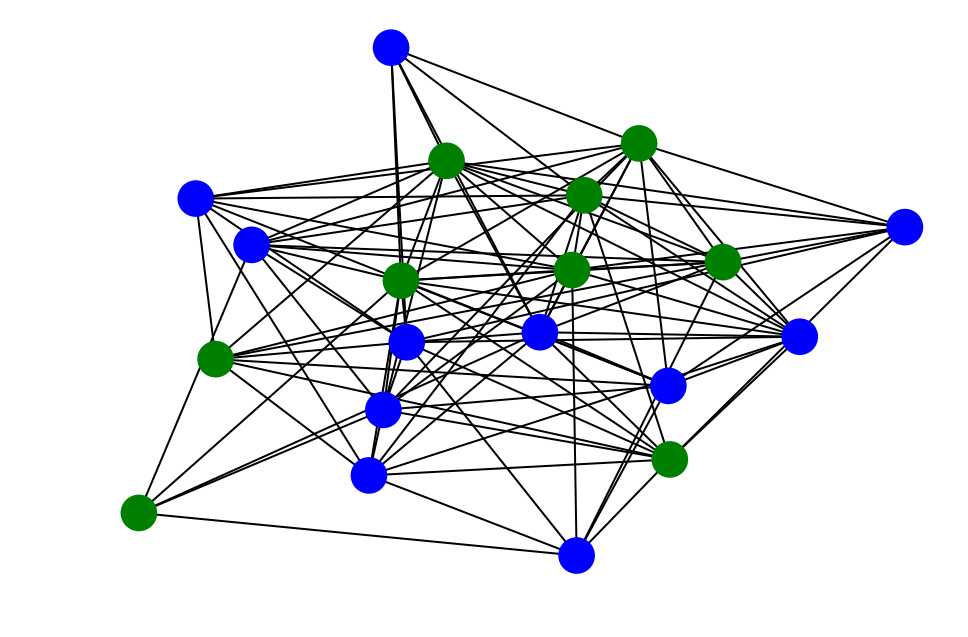

Random Cut Performance
Cut size: 56


In [7]:
random_cut = cvxgr.algorithms.random_cut(graph, 0.5)
visualize_cut(graph, random_cut)

print('Random Cut Performance')
print('Cut size:', random_cut.evaluate_cut_size(graph))

### 1.2.2 Greedy Cut Algorithm

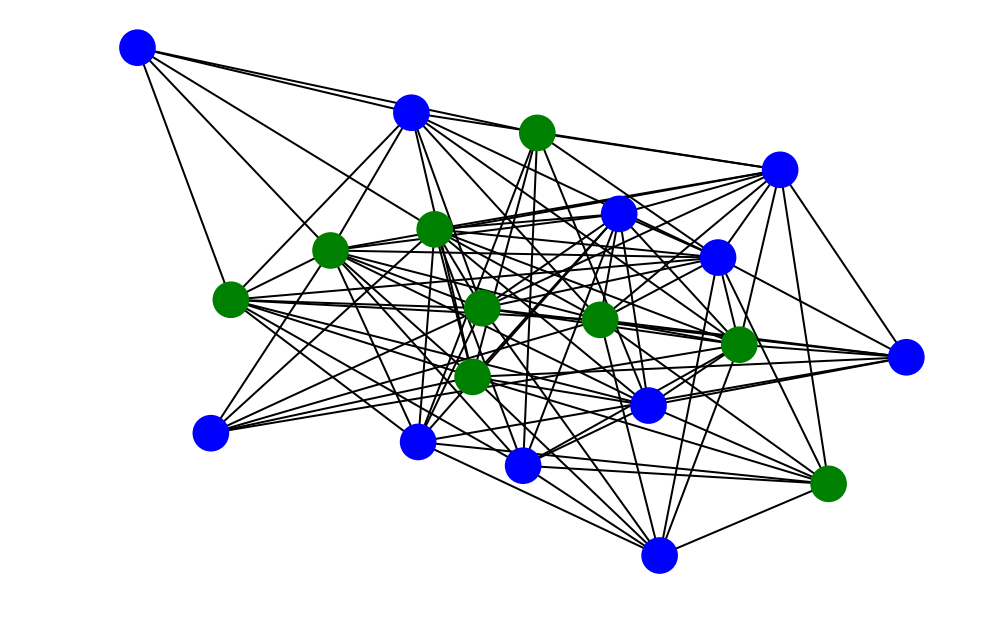

Greedy Cut Performance
Cut size: 65


In [8]:
greedy_cut = cvxgr.algorithms.greedy_max_cut(graph)
visualize_cut(graph, greedy_cut)

print('Greedy Cut Performance')
print('Cut size:', greedy_cut.evaluate_cut_size(graph))

### 1.2.3 Goemans-Williamson Algorithm

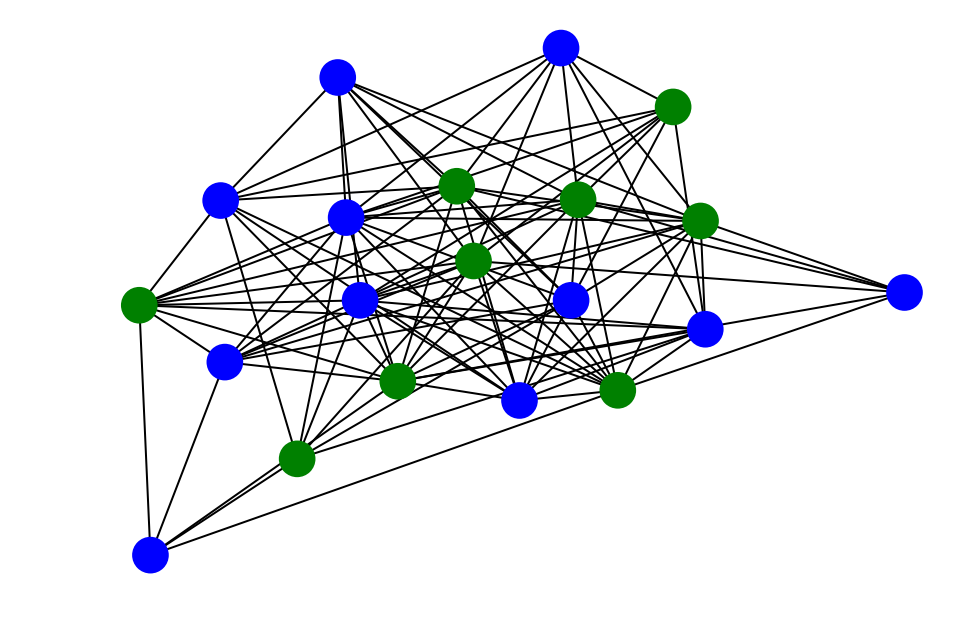

Goemans-Williamson Performance
Cut size: 68


In [9]:
sdp_cut = cvxgr.algorithms.goemans_williamson_weighted(graph)
visualize_cut(graph, greedy_cut)

print('Goemans-Williamson Performance')
print('Cut size:', sdp_cut.evaluate_cut_size(graph))

## 1.3 Performance Testing

In [10]:
random_cut_alg = lambda graph: cvxgr.algorithms.random_cut(graph, 0.5)
greedy_cut_alg = cvxgr.algorithms.greedy_max_cut
sdp_cut_alg = cvxgr.algorithms.goemans_williamson_weighted

### 1.3.1 Erdős–Rényi model

In [11]:
BERNOULLI_PARAM = 0.2
GRAPH_SIZES = [5, 10, 25, 50, 100]

In [12]:
random_results = []
greedy_results = []
sdp_results = []

for size in GRAPH_SIZES:
    generator = lambda: nx.generators.binomial_graph(size, BERNOULLI_PARAM)
    random_results.append(average_performance(generator, random_cut_alg))
    greedy_results.append(average_performance(generator, greedy_cut_alg))
    sdp_results.append(average_performance(generator, sdp_cut_alg))

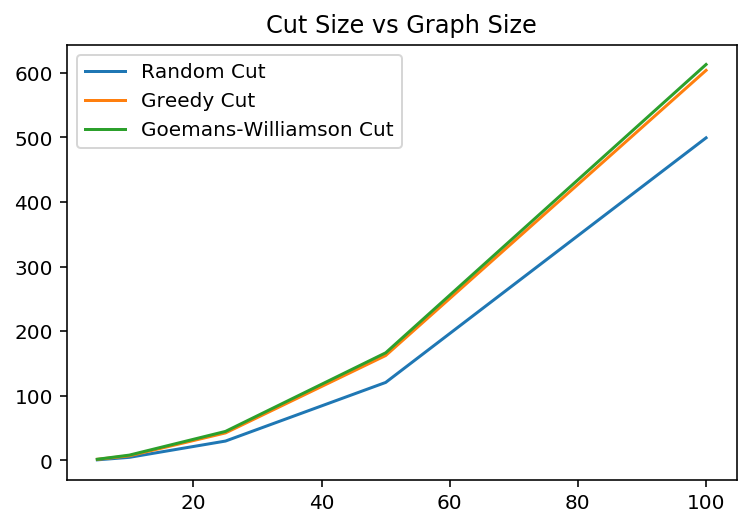

In [13]:
PLOTTING_OPTIONS = {
    'title': 'Cut Size vs Graph Size',
    'legend': [
        'Random Cut',
        'Greedy Cut',
        'Goemans-Williamson Cut'
    ]
}

plt.plot(GRAPH_SIZES, [result['output'] for result in random_results])
plt.plot(GRAPH_SIZES, [result['output'] for result in greedy_results])
plt.plot(GRAPH_SIZES, [result['output'] for result in sdp_results])
plt.title(PLOTTING_OPTIONS['title'])
plt.legend(PLOTTING_OPTIONS['legend'])
plt.show()

In [14]:
rows = []
for pos in range(len(GRAPH_SIZES)):
    rows.append([
        GRAPH_SIZES[pos],
        random_results[pos]['output'],
        greedy_results[pos]['output'],
        sdp_results[pos]['output']
    ])

table = pd.DataFrame(rows)
table.columns = ['Graph Size', 'Random', 'Greedy', 'Goemans-Williamson']
table

,Graph Size,Random,Greedy,Goemans-Williamson
0,5,0.98,1.76,1.86
1,10,4.84,7.20,8.30
2,25,30.04,42.66,45.00
3,50,120.80,162.46,166.66
4,100,499.46,603.92,613.02


### 1.3.2 Stochastic Block Model

In [15]:
GRAPH_SIZE = 20
WITHIN = 0.25
BETWEEN = 0.75

In [16]:
random_results = []
greedy_results = []
sdp_results = []

for size in GRAPH_SIZES:
    generator = lambda: sbm_graph(size, WITHIN, BETWEEN)[0]
    random_results.append(average_performance(generator, random_cut_alg))
    greedy_results.append(average_performance(generator, greedy_cut_alg))
    sdp_results.append(average_performance(generator, sdp_cut_alg))

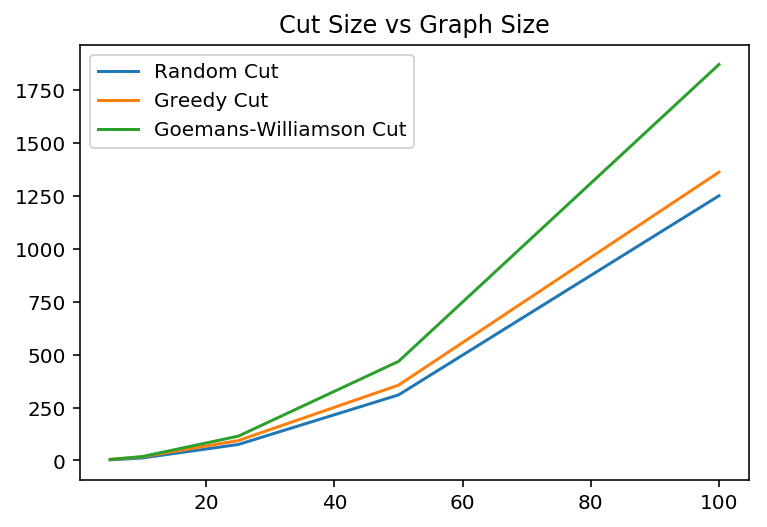

In [17]:
PLOTTING_OPTIONS = {
    'title': 'Cut Size vs Graph Size',
    'legend': [
        'Random Cut',
        'Greedy Cut',
        'Goemans-Williamson Cut'
    ]
}

plt.plot(GRAPH_SIZES, [result['output'] for result in random_results])
plt.plot(GRAPH_SIZES, [result['output'] for result in greedy_results])
plt.plot(GRAPH_SIZES, [result['output'] for result in sdp_results])
plt.title(PLOTTING_OPTIONS['title'])
plt.legend(PLOTTING_OPTIONS['legend'])
plt.show()

In [18]:
rows = []
for pos in range(len(GRAPH_SIZES)):
    rows.append([
        GRAPH_SIZES[pos],
        random_results[pos]['output'],
        greedy_results[pos]['output'],
        sdp_results[pos]['output']
    ])

table = pd.DataFrame(rows)
table.columns = ['Graph Size', 'Random', 'Greedy', 'Goemans-Williamson']
table

,Graph Size,Random,Greedy,Goemans-Williamson
0,5,2.86,4.82,4.58
1,10,11.72,16.92,18.22
2,25,75.44,94.00,114.84
3,50,309.58,355.78,468.06
4,100,1250.52,1362.08,1870.92
